## Overview

In this notebook, we will be tackling classification using the MNISt dataset.
First Let's import the data from Scikit learn library

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

e:\programming\AI\Machine-Learning-Projects\Project1\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's have a look at the target and data arrays to see what they contain:

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. so each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

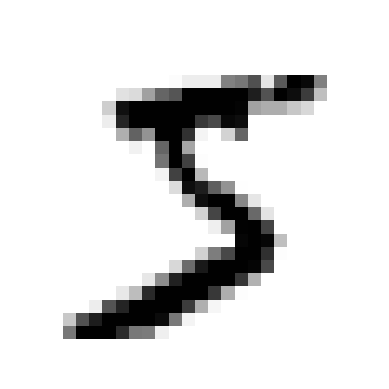

In [4]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

X= np.array(X)
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [5]:
y[0]

'5'

Since most values are expected to be integers so we can reduce size of y labels

In [6]:
y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1-Training a Binary Classifier


Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let pick a model and train it on the data . we will be using a Stochastic Gradi‐
ent Descent (SGD) classifier. it has the property of ealing with large datasets effiecently

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [10]:
sgd_clf.predict([some_digit])


array([ True])

## 2-Performance Measures


### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation.Let’s use the cross_val_score() with 3 folds.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

let's compare the results with a dumb model that returns 0 every single time

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
    return self
 def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

It's so closee !!! that's sus, that's demonstrate that accuracy is not always a good startegy to evaluate your model performance

### Confusion Matrix


To compute the confusion matrix, we first need to have a set of predictions so that
they can be compared to the actual targets. let's do that using the following code:

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):

In [16]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The precesion (precision = TP/(TP + FP)) is one of the metrics that we can extract from the confusion matrix . it represents the propotion of true positives predicted of all the positives predicted. Having a perfect precision means in other terms predicting only 1 label and that's prediction is true 1/1= 100%. but that's not interesting that why we have another metric called recall. it actually represents the propotion of true positive predicted from all the predictions

recall = TP/(TP + FN) with TP are the true positives , FP are the false positives and FN are the false negatives!

### Precision and Recall Implementation


In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

as we can see the results aren't that promising as before !!

For that we can use another metric called The F1 metric or the harmonic mean that combines both precision and recall such as :


F1=2 * prec *recall/(prec + recall)

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. Which is not we want for all cases , sometimes we want to ensure that all what predict is actually positive high precision . and sometimes we want to predict as much true positive as possible without caring about the number of actual negatives that we predicted as positive ( high recall )

### Precision/Recall Trade-off


we can use the SGDClassifier . it has a threshold so that if the number is on the right , it predicts 5 else it's not 5 . by moving the treshold the right u are increasing the precision but decreasing the recal . and that's what precision/ recall is all about ! 

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Having a threshold equal to 0 is like calling the predict() method, let's now raise the threshold:

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.

But now how to decide what treshold to have ! we will use cross_val_predict() function to get the scores of all instances in the training set, but this time specifying that we want to return decision scores instead of predictions:

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")


We can then use those scores to calculate the precision and recall for all possible thresholds using the precision_recall_curve() function:

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

now we will plot the results !

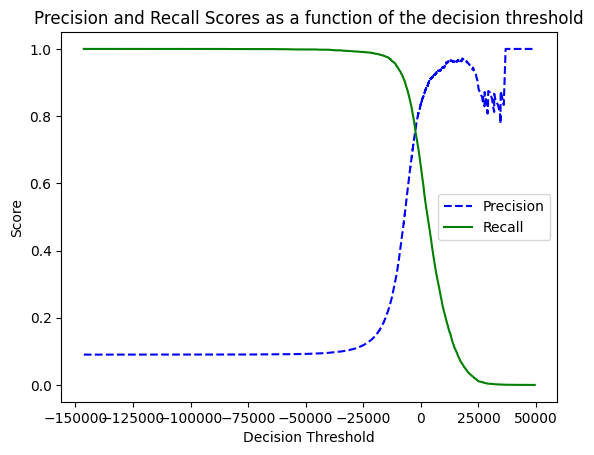

In [25]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

# assuming precisions, recalls, thresholds are defined
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


sometimes the precision goes down when u increase the threshold, that's why it's not a good idea to select a threshold based on the precision/recall curve, you should select it based on your needs , we can use instead recall vs precision

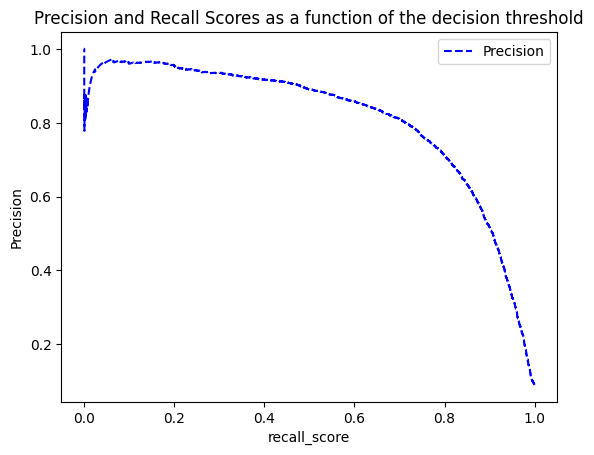

In [26]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(precisions, recalls):
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(recalls, precisions, "b--", label="Precision")
    plt.ylabel("Precision")
    plt.xlabel("recall_score")
    plt.legend(loc='best')

# assuming precisions, recalls, thresholds are defined
plot_precision_vs_recall(precisions, recalls)
plt.show()


we can create a classifier with 90% precision using the np.argmax method

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

let's predict the results using the following code ! 

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

let's see the precision and recall of the result

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The ROC curve is another representation of precision and recall but instead of plotting them against each other, it plots The True Positive Rate (recall) against the False Positive Rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the True Negative Rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 - specificity.

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

We will now plot the result

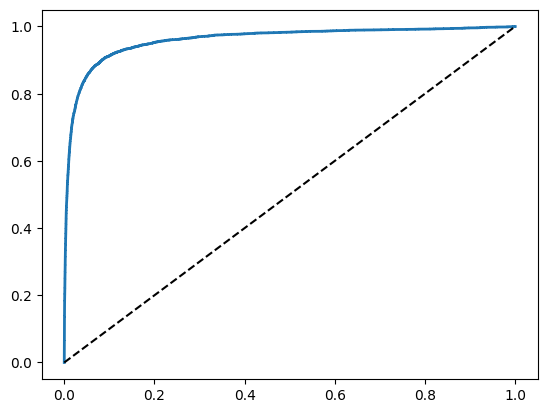

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
 [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()


We can now compare classifiers by measuring the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

This may seem perfect but it's not the case , u may wonder when to use ROC and when to use PR curve, we use PR curve when the positive class is rare or when u care more about the false positives than the false negatives, and the ROC curve otherwise.

Now let's use a RandomForestClassifier and compare its ROC curve and ROC AUC to the SGDClassifier that we trained earlier:

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
 method="predict_proba")


even though the roc_curve function accepts scores , we can also give it class probabilities

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

we can now plot the results :

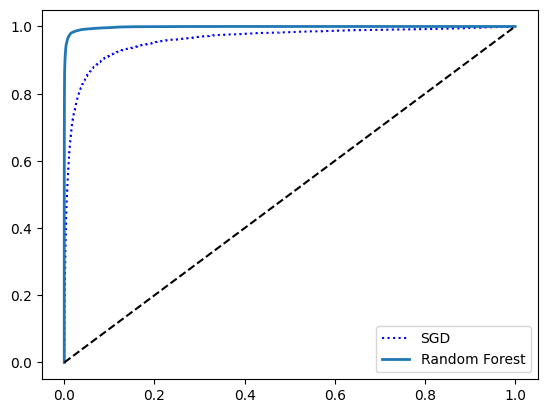

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As we can see , the Random Forest Classifier is much better than the SGD Classifier as the ROC curve is much closer to the top-left corner and it has a greater AUC score as well.

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

Wow that's interesting! The Random Forest Classifier is superior to the SGD Classifier because its ROC AUC score is significantly larger.

In [39]:
precision_score(y_train_5, (y_scores_forest > 0.5))

0.9905083315756169

In [40]:
recall_score(y_train_5, (y_scores_forest > 0.5))

0.8662608374838591

Not Bad , 99% precision and 86% recall score !!!!

## 3-Multiclass Classification

There are many techniques to create a multiclassifier , one of them is to use SGD , random forests or naive bayes classifiers , but we can also use binary classifiers such as logistic regression to do a multiclassification task . That can be done using one vs all or one vs one strategies . In one vs all strategy , we train a binary classifier for each class , and then we select the class with the highest score . In one vs one strategy , we train a binary classifier for each pair of classes , and then we select the class that wins the most duels . The main advantage of one vs one strategy is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish .

In [41]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])


array([5], dtype=uint8)

That was easy! This code trains the SVC on the training set using the original target
classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes
(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels.

let's call the decision_function() method to see the score for each class:

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [43]:
np.argmax(some_digit_scores)

5

There are actually 10 classes :

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[5]


5

If we want to force ScikitLearn to use one-versus-one or one-versus-all, we can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply we can create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [47]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovr_clf.estimators_)

10

Let's train and SGDClassifier now on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5):

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

The interesting part is that the sgd_clf didn't need to use OvR or OvO because SGD classifiers can directly classify instances into multiple classes. We can call the decision_function() method to see that the classifier is indeed confident about its prediction:

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

we can see that the classifier is confident about the prediction: almost all scores are largely negative, while class 4 has a score of 1823.7 . The model has a slight doubt regarding class 3, which gets a score of 658.1. Now of course you want to evaluate this classifier. As usual, you can use cross-validation. Use the cross_val_score() function to evaluate the SGDClassifier’s accuracy.

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 4-Error Analysis

let's analyze the errors:

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

that's confusing a little bit , let's plot it using matplotlib:

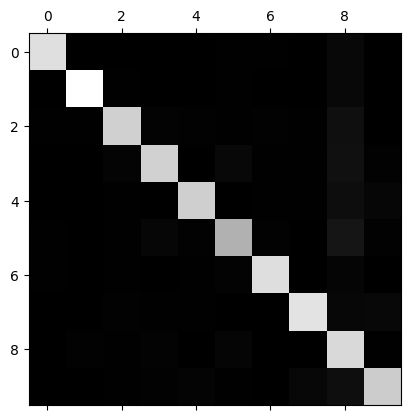

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

as u can see the diagonal is white which means that the model is good, but the 5s are a bit darker than the other digits which means that there are less 5s than the other digits, let's focus on errors now, first let's divide each value in the confusion matrix by the number of images in the corresponding class so we can compare error rates instead of absolute number of errors:

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

let's fill the diagonal with zeros to keep only the errors, and let's plot the result ( the rows represent the actual classes and the columns represent the predicted classes):

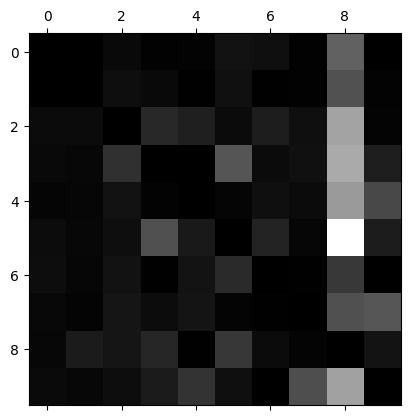

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

let's plot now 

In [69]:
def plot_digits(data, images_per_row=5):
    size = 28
    images_per_row = min(len(data), images_per_row)
    images = [instance.reshape(size,size) for instance in data]
    n_rows = (len(data) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(data)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary)
    plt.axis("off")


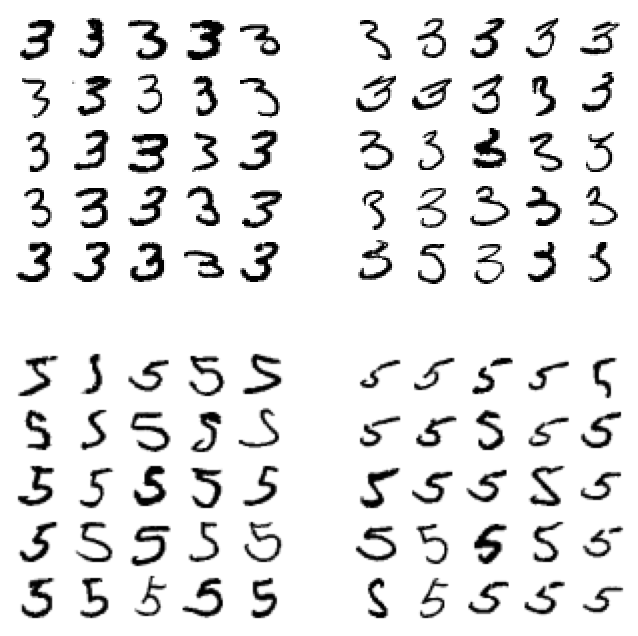

In [61]:
import matplotlib
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks
on the right show images classified as 5s. Some of the digits that the classifier gets
wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a
human would have trouble classifying them (e.g., the 5 in the first row and second
column truly looks like a badly written 3). However, most misclassified images seem
like obvious errors to us, and it’s hard to understand why the classifier made the mis‐
takes it did. 

## 5-Multilabel Classification

it's like the regular classification but we expect more than 1 element in the output . for example , let's say we are using a face detection model , what will happen if the picture contains more than 1 face 

In [63]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [64]:
knn_clf.predict([some_digit])


array([[False,  True]])

that's true , 5 is not greater than 7 and it is odd

we can use the F1 Score to evaluate our KNN classifier

In [65]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [ ]:
By setting the average to macro ,we assume that all labels are equally important, however, which may not be the
case. we can set it to weighted instead

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

## 6-Multioutput Classification


It is actually a generalizatioin for both multiclass and multilabeled classification, a great example would be a system that removes noise from images. the input will be an images and the output will be a clean image, represented as a pixel intensity array, just like the MNIST images. The pixels will be the labels, and they can have any value between 0 and 255. Therefore, it will be a multilabel classification system (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

first let's create the noisy dataset: 

In [67]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

let's now fit our classifier and make it clean an image

In [70]:
def plot_digit(data):
    size = 28
    image = data.reshape(size, size)
    plt.imshow(image, cmap = matplotlib.cm.binary)
    plt.axis("off")

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

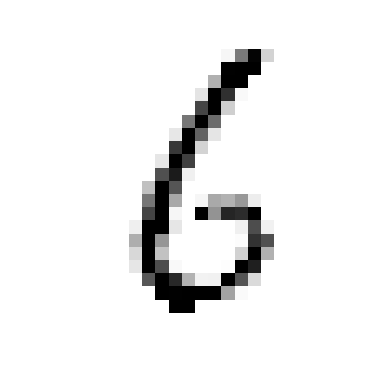

In [75]:
clean_digit = knn_clf.predict([X_test_mod[50]])
plot_digit(clean_digit)